# Vehicle Detection
    
The goals / steps of this project are the following:

   - Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
   - Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
   - Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
   - Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
   - Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
   - Estimate a bounding box for vehicles detected.



In [2]:
# import needed packages
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.externals import joblib
from skimage.feature import hog
from tqdm import tqdm
from PIL import Image
from collections import deque
from itertools import chain

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

## Helper Functions

In [33]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# function to extract features from a single image
def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    
    # define an empty list to receive features
    img_features = []
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
        
    # spatial features
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    # color features
    if color_feat:
        rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        img_features.append(hist_features)
        
    # HOG features
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # append features to list
        img_features.append(hog_features)

    # return concatenated array of features
    return np.concatenate(img_features)
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [3]:
# import training images
veh_images = glob.glob('./training_images/vehicles/**/*.png')
nonveh_images = glob.glob('./training_images/non-vehicles/**/*.png')

print("Vehicle Images: "+str(len(veh_images)))
print("Non-vehicle Images: "+str(len(nonveh_images)))

Vehicle Images: 8792
Non-vehicle Images: 8968


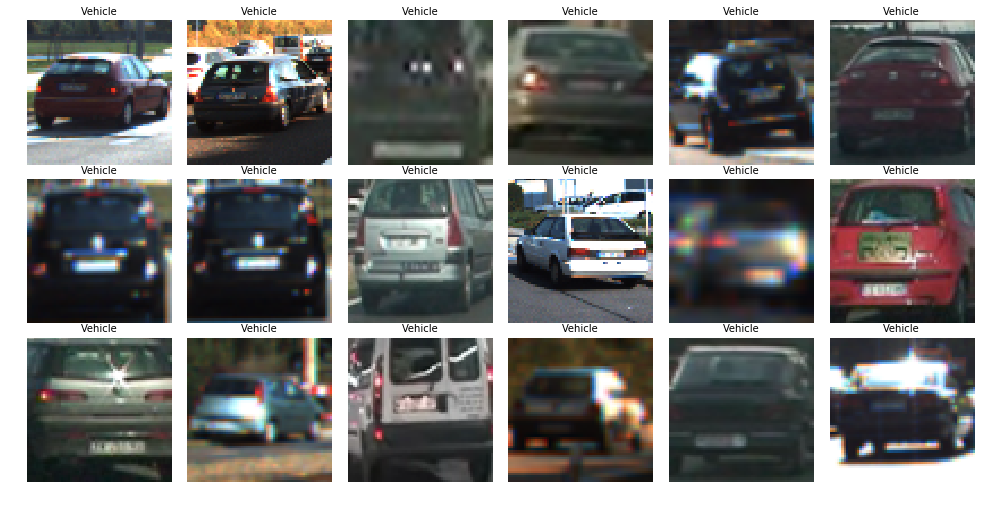

In [4]:
# plot vehicles
f, ax = plt.subplots(3,6, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()


for i in range(18):
    img1 = cv2.imread(veh_images[np.random.randint(0,len(veh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Vehicle', fontsize=10)
    ax[i].imshow(img1)
    
# save image for write up
# f.savefig("output_images/vehicles.png")



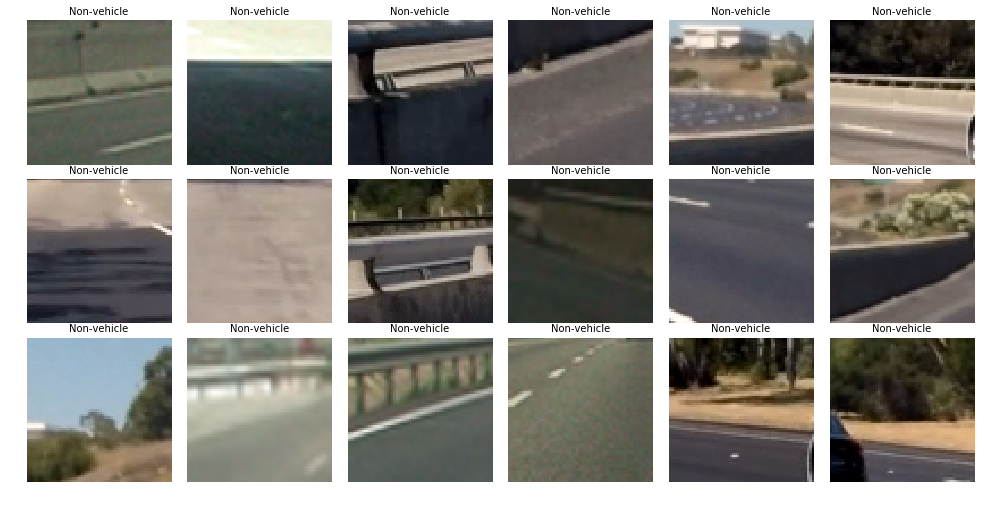

In [5]:
# plot non-vehicles
f, ax = plt.subplots(3,6, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i in range(18):
    img1 = cv2.imread(nonveh_images[np.random.randint(0,len(nonveh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Non-vehicle', fontsize=10)
    ax[i].imshow(img1)
    
# save image for write up
#f.savefig("output_images/non_vehicles.png")

The images extracted show that in the vehicles folder there are images of vehicles of various angles, crops, and zooms. In the non-vehicle folder we have images of typical scenes that you might see driving without any other vehicles around.

/home/mikedef/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  del sys.path[0]


[(865, 544), (826, 583)]


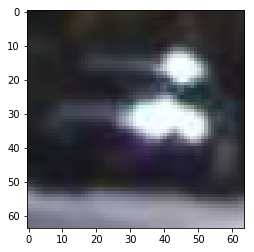

In [6]:
# using additional images udacity
labels_df = pd.read_csv("training_images/labels.csv")
car_labels = labels_df[labels_df['Label']=='Car'].reset_index()

car_labels['window'] = car_labels.apply(lambda x: [(x['ymin'],x['xmax']),(x['xmin'], x['ymax'])], axis=1)
car_labels

# test to see new images
img_idx = 6243

# read in image
crowdai_path = "training_images/object-detection-crowdai/"
image = cv2.imread(crowdai_path+car_labels.ix[img_idx,'Frame'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

extracted_image = draw_boxes(image, [car_labels.ix[img_idx,'window']])
print(car_labels.ix[img_idx,'window'])

plt.imshow(extracted_image)
img = cv2.resize(image[car_labels.ix[img_idx,'window'][0][1]:car_labels.ix[img_idx,'window'][1][1], 
                        car_labels.ix[img_idx,'window'][1][0]:car_labels.ix[img_idx,'window'][0][0]], (64, 64))

plt.imshow(img)

In [7]:
# Look into saving the udacity downloaded imgs

## Extracting Features

### Histogram of Gradients (HOG)

To extract the HOG fetures I defined a function  `get_hog_features()` 

/home/mikedef/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


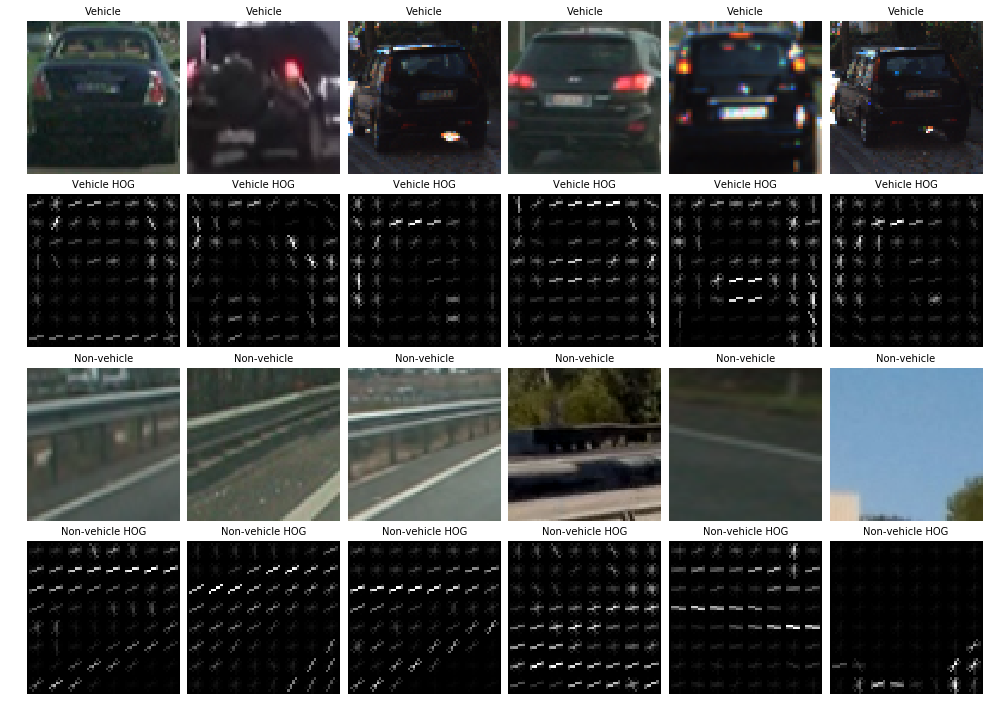

In [8]:
# plot images
f, ax = plt.subplots(4,6, figsize=(14, 10))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()
    
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Extract and plot HOG features in Vehicle images
for i in range(6):
    ## plot img
    img1 = cv2.imread(veh_images[np.random.randint(0,len(veh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Vehicle', fontsize=10)
    ax[i].imshow(img1)
    
    ## plot hog
    gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    _, hog_img = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    ax[i+6].axis('off')
    ax[i+6].set_title('Vehicle HOG', fontsize=10)
    ax[i+6].imshow(hog_img, cmap='gray')

# Extract and plot HOG features in Non-Vehicle images
for i in range(12,18):
    ## plot img
    img1 = cv2.imread(nonveh_images[np.random.randint(0,len(nonveh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Non-vehicle', fontsize=10)
    ax[i].imshow(img1)
    
    ## plot hog
    gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    _, hog_img = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    ax[i+6].axis('off')
    ax[i+6].set_title('Non-vehicle HOG', fontsize=10)
    ax[i+6].imshow(hog_img, cmap='gray')
    
# save image for write up
#f.savefig("output_images/hog_examples.png")

It is easy to see the difference between the Vehicle HOG images and the Non-Vehicle HOG images

### Color Features

<Container object of 32 artists>

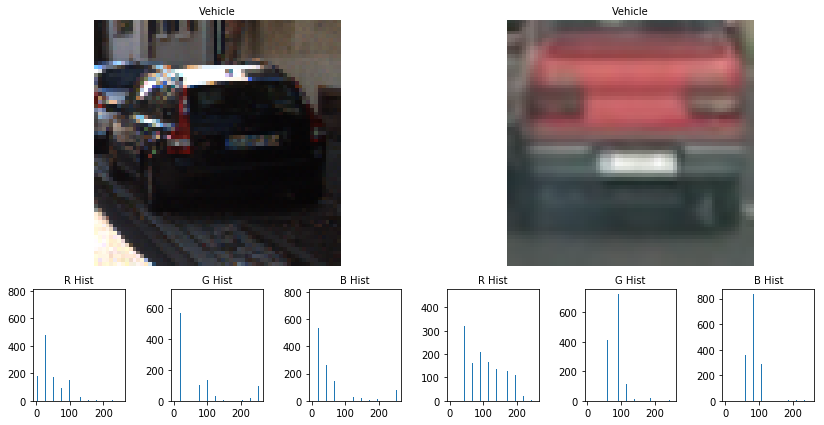

In [9]:
# setup figure
f = plt.figure(figsize=(14, 7))
f.subplots_adjust(hspace = .2, wspace=.5)

# image 1
img1 = cv2.imread(veh_images[2043])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(img1, nbins=32, bins_range=(0, 256))

# plot image
ax1 = plt.subplot2grid((3,6), (0,0), rowspan=2, colspan=3)
ax1.axis('off')
ax1.set_title('Vehicle', fontsize=10)
ax1.imshow(img1)

# R Hist
ax3 = plt.subplot2grid((3,6), (2,0))
ax3.set_title('R Hist', fontsize=10)
ax3.bar(bincen, rh[0])

# G hist
ax4 = plt.subplot2grid((3,6), (2,1))
ax4.set_title('G Hist', fontsize=10)
ax4.bar(bincen, gh[0])

# B hist
ax5 = plt.subplot2grid((3,6), (2,2))
ax5.set_title('B Hist', fontsize=10)
ax5.bar(bincen, bh[0])


# image 2
img1 = cv2.imread(veh_images[230])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(img1, nbins=32, bins_range=(0, 256))

# plot image
ax2 = plt.subplot2grid((3,6), (0,3), rowspan=2, colspan=3)
ax2.axis('off')
ax2.set_title('Vehicle', fontsize=10)
ax2.imshow(img1)

# R Hist
ax6 = plt.subplot2grid((3,6), (2,3))
ax6.set_title('R Hist', fontsize=10)
ax6.bar(bincen, rh[0])

# G hist
ax7 = plt.subplot2grid((3,6), (2,4))
ax7.set_title('G Hist', fontsize=10)
ax7.bar(bincen, gh[0])

# B hist
ax8 = plt.subplot2grid((3,6), (2,5))
ax8.set_title('B Hist', fontsize=10)
ax8.bar(bincen, bh[0])

# save image for write up
#f.savefig("output_images/color_hist.png")

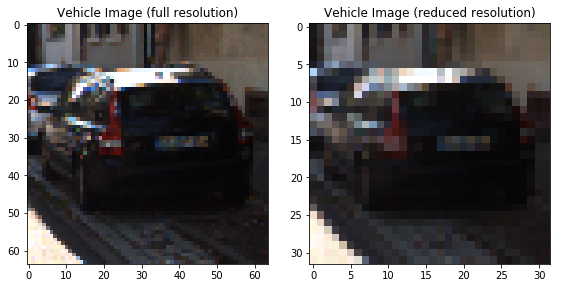

In [10]:
# read image 
img1 = cv2.imread(veh_images[2043])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)

# Look at the reduced resolution image
feature_vec = bin_spatial(img1, color_space='RGB', size=(32, 32))

# plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
f.tight_layout()

ax1.imshow(img1)
ax1.set_title('Vehicle Image (full resolution)', fontsize=12)

ax2.imshow(feature_vec.reshape((32,32,3)))
ax2.set_title('Vehicle Image (reduced resolution)', fontsize=12)

# save image for write up
#f.savefig("output_images/spatial_bin.png")

This reduces the images resolution but we can still make out the vehicle enough to capture valid information

Next I will used the pipeline I created in the function `extract_features` to extract color, gradient, and HOG features and build my classifier based on these features.

### Classifying Images


In [15]:
# define parameters for feature extraction
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0,256)
spatial_feat = True
color_feat = True
hog_feat = True

random.seed(999)

t=time.time()
# extract vehicle image features
car_features = extract_features(veh_images, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=color_feat, hog_feat=hog_feat)

#add_car_features = extract_features(add_veh_images, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
#                                hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
#                                cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                                hist_feat=color_feat, hog_feat=hog_feat)

car_features = car_features # + add_car_features

print('Total vehicle images: ', len(car_features))

# extract non vehicle image features
notcar_features = extract_features(nonveh_images, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                   hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   hist_feat=color_feat, hog_feat=hog_feat)

add_notcar_features = random.sample(notcar_features, 7000)

notcar_features = notcar_features + add_notcar_features

print('Total non-vehicle images: ', len(notcar_features)) 
t2 = time.time()

print(round(t2-t, 2), 'seconds to extract features')

/home/mikedef/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Total vehicle images:  8792
Total non-vehicle images:  15968
48.9 seconds to extract features


In [16]:
# combine observations
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
X_scaler = RobustScaler().fit(X)

# apply the scaler to X
scaled_X = X_scaler.transform(X)

# define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# split up data into randomized training and test sets
rand_state = 22
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)



## Model Training

In [17]:
# print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# use random forest
rf = RandomForestClassifier()

# check the training time for the RF
t=time.time()
rf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train RF')

# check the score of the RF
print('Test Accuracy of RF = ', round(rf.score(X_test, y_test), 4))

# check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', rf.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with RF')

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
7.75 seconds to train RF
Test Accuracy of RF =  0.9881
Model predicts:  [ 0.  1.  1.  1.  1.  0.  0.  0.  0.  0.]
Actual labels:   [ 0.  1.  1.  1.  1.  0.  0.  0.  0.  0.]
0.00358 Seconds to predict 10 labels with RF


In [18]:
# print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# use random forest
rf_1 = RandomForestClassifier(n_estimators=50, min_samples_split=7, min_samples_leaf=1)

# check the training time for the RF
t=time.time()
rf_1.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train RF')

# check the score of the RF
print('Test Accuracy of RF = ', round(rf_1.score(X_test, y_test), 4))

# check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', rf_1.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with RF')


Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
41.79 seconds to train RF
Test Accuracy of RF =  0.9935
Model predicts:  [ 0.  1.  1.  1.  1.  0.  0.  0.  0.  0.]
Actual labels:   [ 0.  1.  1.  1.  1.  0.  0.  0.  0.  0.]
0.00783 Seconds to predict 10 labels with RF


In [19]:
# train the model on all of the data
rf_final = RandomForestClassifier(n_estimators=50, min_samples_split=7, min_samples_leaf=1)
rf_final.fit(scaled_X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=7, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

## Sliding Window Search

A sliding window approach has been implemented, where overlapping tiles in each test image are classified as vehicle or non-vehicle. 

In [30]:
# function so search through an image
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # create an empty list to receive positive detection windows
    on_windows = []
    
    # iterate over all windows in the list
    for window in windows:
        
        # extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        # extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=color_feat, hog_feat=hog_feat)
        
        # scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # predict using your classifier
        prediction = clf.predict(test_features)
        ## if positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    # return windows for positive detections
    return on_windows

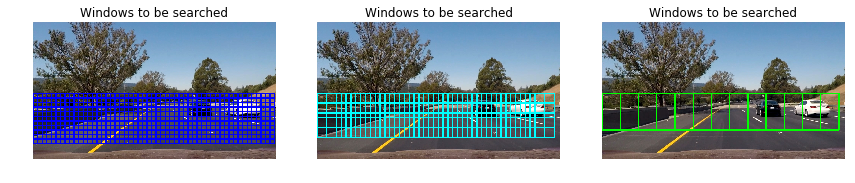

In [31]:
# read in the file paths to the test images
test_imgs = glob.glob('./test_images/*.jpg')

# read in image
image_orig = cv2.imread(test_imgs[0])
image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
image = image_orig.astype(np.float32)/255

# create boundary for search
y_start_stop = [375, 640]

# create windows to be searched
window_sizes = [96, 128, 192]
colors = [(0,0,255),(0,255,255),(0,255,0)]
windows_img = np.copy(image)
windows = []

for idx, window_size in enumerate(window_sizes):
    # find windows at different scales
    temp_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_size, window_size), xy_overlap=(0.75, 0.75))
    
    # adding the new windows
    windows += temp_windows


# create windows
windows_1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_sizes[0], window_sizes[0]), xy_overlap=(0.75, 0.75))
windows_2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_sizes[1], window_sizes[1]), xy_overlap=(0.6, 0.6))
windows_3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_sizes[2], window_sizes[2]), xy_overlap=(0.5, 0.5))

# add windows to images
windows_1_img = draw_boxes(image_orig, windows_1, color=colors[0])
windows_2_img = draw_boxes(image_orig, windows_2, color=colors[1])
windows_3_img = draw_boxes(image_orig, windows_3, color=colors[2])

# plot the images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
f.tight_layout()

ax1.imshow(windows_1_img)
ax1.axis('off')
ax1.set_title('Windows to be searched', fontsize=12)

ax2.imshow(windows_2_img)
ax2.axis('off')
ax2.set_title('Windows to be searched', fontsize=12)

ax3.imshow(windows_3_img)
ax3.axis('off')
ax3.set_title('Windows to be searched', fontsize=12)

# save image for write up
#f.savefig("output_images/search_windows_separate.png")

Seach the windows above for positive hits for vehicles

/home/mikedef/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


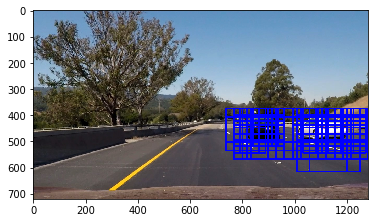

In [34]:
# search windows and classify cars
hot_windows = search_windows(image, windows, rf_final, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=color_feat, hog_feat=hog_feat)                       

# draw boxes around possible cars
window_img = draw_boxes(image_orig, hot_windows)                    

plt.imshow(window_img)

plt.savefig("output_images/located_cars.png")

In [35]:
# function to create heatmap
def add_heat(heatmap, bbox_list):
    
    # iterate through list of bboxes
    for box in bbox_list:
        
        # add += 1 for all pixels inside each bbox
        # assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
# create a mask based on the heatmap
def apply_threshold(heatmap, threshold):
    
    # zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

# final boxes around cars
def draw_labeled_bboxes(img, labels, ret_bbox=False):
    
    all_bbox = []
    
    # iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        all_bbox.append(bbox)
        
    if ret_bbox:
        return img, all_bbox
    else:
        return img

# define a single function that can extract features
def find_cars(img, y_start_stop, window_sizes, clf, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
             hog_channel, spatial_feat, color_feat, hog_feat, test_flag=True, windows_flag=False, heat_flag=False):
    
    img_orig = np.copy(img)
    
    # convert jpg for test images
    if test_flag:
        img = img_orig.astype(np.float32)/255
    
    # create empty windows list
    windows = []
    
    # varying overlap
    overlap = [0.75, 0.6, 0.5]

    for idx, window_size in enumerate(window_sizes):
        # find windows at different scales
        temp_windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                               xy_window=(window_size, window_size), xy_overlap=(overlap[idx], overlap[idx]))

        # adding the new windows
        windows += temp_windows
    
    # search windows and classify cars
    hot_windows = search_windows(img, windows, clf, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=color_feat, hog_feat=hog_feat)                       

    # draw boxes around possible cars
    window_img = draw_boxes(img_orig, hot_windows)
    
    # create empty heatmap
    heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

    # add heat to each box in box list
    heatmap_mask = add_heat(heatmap_mask, hot_windows)

    # apply threshold to help remove false positives
    heatmap_mask = apply_threshold(heatmap_mask,7)

    # visualize the heatmap when displaying    
    heat_img = np.clip(heatmap_mask, 0, 255)

    # find final boxes from heatmap using label function
    labels = label(heat_img)
    final_img = draw_labeled_bboxes(np.copy(img_orig), labels)
    
    if all([windows_flag,heat_flag]):
        return window_img, heat_img
    elif windows_flag:
        return window_img
    elif heat_flag:
        return heat_img
    else:
        return final_img

# function to convert color
def convert_color(img, conv='RGB2LUV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    
# define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_efficient(img, y_start_stop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                        hist_bins, test_flag=True, windows_flag=False, heat_flag=False):
    
    img_orig = np.copy(img)
    draw_img = np.copy(img)
    
    # convert jpg for test images
    if test_flag:
        img = draw_img.astype(np.float32)/255
    
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2LUV')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hot_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            rh, gh, bh, bincen, hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                bbox = ((xbox_left, ytop_draw+y_start_stop[0]), (xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0]))

                # store the bounding box if its a car
                hot_windows.append(bbox)
                cv2.rectangle(draw_img,bbox[0], bbox[1],(0,0,255),6)
            
    
    # create empty heatmap
    heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

    # add heat to each box in box list
    heatmap_mask = add_heat(heatmap_mask, hot_windows)

    # apply threshold to help remove false positives
    heatmap_mask = apply_threshold(heatmap_mask,3)

    # visualize the heatmap when displaying    
    heat_img = np.clip(heatmap_mask, 0, 255)

    # find final boxes from heatmap using label function
    labels = label(heat_img)
    final_img = draw_labeled_bboxes(np.copy(img_orig), labels)
         
    if all([windows_flag,heat_flag]):
        return draw_img, heat_img
    elif windows_flag:
        return draw_img
    elif heat_flag:
        return heat_img
    elif final_img is not None:
        return final_img
    else:
        return img

In [ ]:
# set parameters
y_start_stop = [375, 640]
window_sizes = [64, 96, 156]
clf = rf_final
X_scaler = X_scaler

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0,256)
spatial_feat = True
color_feat = True
hog_feat = True

test_flag = True
windows_flag = True
heat_flag = False

# plot vehicles
f, ax = plt.subplots(2,3, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i in range(6):
    ## read in image
    img1_orig = cv2.imread(test_imgs[i])
    img1_orig = cv2.cvtColor(img1_orig,cv2.COLOR_BGR2RGB)
    
    ## run the pipeline
    output_img = find_cars(img1_orig, y_start_stop, window_sizes, rf_final, X_scaler, color_space, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, hog_channel, spatial_feat, color_feat, hog_feat, 
                           test_flag, windows_flag, heat_flag)
    
    ## plot image
    ax[i].axis('off')
    ax[i].imshow(output_img)
    
# save image for write up
#f.savefig("output_images/vehicle_final.png")

/home/mikedef/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


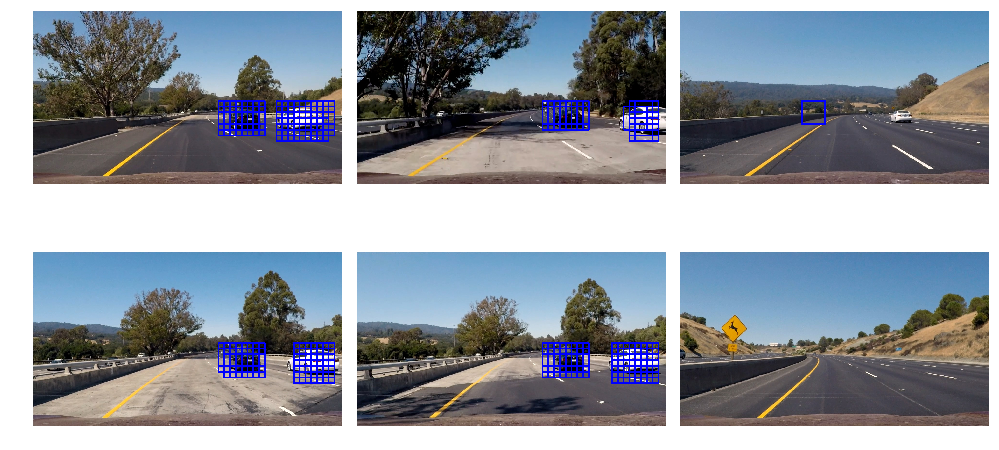

In [38]:
# set parameters
y_start_stop = [375, 640]
scale = 1.5
clf = rf_final
X_scaler = X_scaler
orient = 8
pix_per_cell = 8
cell_per_block = 2
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0,256)
test_flag = True
windows_flag = True
heat_flag = False

# plot vehicles
f, ax = plt.subplots(2,3, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i in range(6):
    # read in image
    img1_orig = cv2.imread(test_imgs[i])
    img1_orig = cv2.cvtColor(img1_orig,cv2.COLOR_BGR2RGB)
    
    # run the pipeline
    output_img = find_cars_efficient(img1_orig, y_start_stop, scale, clf, X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, test_flag, windows_flag, heat_flag)
    
    # plot image
    ax[i].axis('off')
    ax[i].imshow(output_img)
    
# save image for write up
#f.savefig("output_images/vehicle_final_efficient.png")

Use a heatmap to control for noise in the images

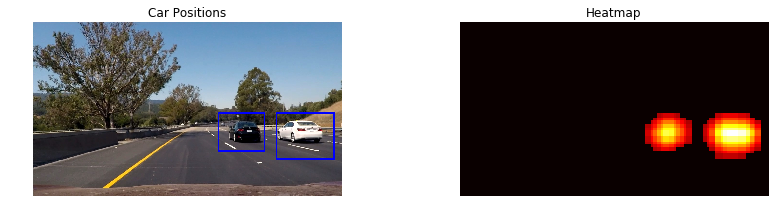

In [39]:
# create empty heatmap
heat_mask = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat_mask = add_heat(heat_mask,hot_windows)
    
# Apply threshold to help remove false positives
heat_mask = apply_threshold(heat_mask,7)

# Visualize the heatmap when displaying    
heatmap_img = np.clip(heat_mask, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap_img)
draw_img = draw_labeled_bboxes(np.copy(image_orig), labels)

# plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
f.tight_layout()

ax1.imshow(draw_img)
ax1.axis('off')
ax1.set_title('Car Positions', fontsize=12)

ax2.imshow(heatmap_img, cmap='hot')
ax2.axis('off')
ax2.set_title('Heatmap', fontsize=12)

# save image for write up
#f.savefig("output_images/heatmap.png")

## Process Video

In [40]:
# parameter dictionary
param_dict = {"y_start_stop":[375, 640],
              "window_sizes":[64, 96, 156],
              "scale":1.5,
              "clf":rf_final,
              "X_scaler":X_scaler,
              "color_space":'LUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
              "orient":8,
              "pix_per_cell":8,
              "cell_per_block":2,
              "hog_channel":0, # Can be 0, 1, 2, or "ALL"
              "spatial_size":(16, 16),
              "hist_bins":32,
              "hist_range":(0,256),
              "spatial_feat":True,
              "color_feat":True,
              "hog_feat":True,
              "test_flag":True,
              "windows_flag":False,
              "heat_flag":False}

# defining a class to keep track of the previous bounding boxes
class Vehicle_Detector:
    
    # initial list of variables to be passed in
    y_start_stop = None
    window_sizes = None
    clf = None
    X_scaler = None
    color_space = None
    orient = None
    pix_per_cell = None
    cell_per_block = None
    spatial_size = None
    hist_bins = None
    hog_channel = None
    spatial_feat = None
    color_feat = None
    hog_feat = None
    test_flag = None
    windows_flag = None
    heat_flag = None
    
    # initialize variables
    def __init__(self, aDict, frames_to_keep=10):
        self.hotbox_hist = deque(maxlen=frames_to_keep)
        self.__dict__.update(aDict)
        
    
    # defining the pipeline
    def pipeline(self, img):
    
        img_orig = np.copy(img)

        # convert jpg for test images
        if self.test_flag:
            img = img_orig.astype(np.float32)/255

        # create empty windows list
        windows = []

        # varying overlap
        overlap = [0.75, 0.6, 0.5]

        for idx, window_size in enumerate(self.window_sizes):
            # find windows at different scales
            temp_windows = slide_window(img, x_start_stop=[None, None], y_start_stop=self.y_start_stop, 
                                   xy_window=(window_size, window_size), xy_overlap=(overlap[idx], overlap[idx]))

            # adding the new windows
            windows += temp_windows

        # search windows and classify cars
        hot_windows = search_windows(img, windows, self.clf, self.X_scaler, cspace=self.color_space, 
                                    spatial_size=self.spatial_size, hist_bins=self.hist_bins, 
                                    orient=self.orient, pix_per_cell=self.pix_per_cell, 
                                    cell_per_block=self.cell_per_block, 
                                    hog_channel=self.hog_channel, spatial_feat=self.spatial_feat, 
                                    color_feat=self.color_feat, hog_feat=self.hog_feat)                       

        # draw boxes around possible cars
        window_img = draw_boxes(img_orig, hot_windows)

        
        # current image #
        # create empty heatmap
        heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

        # add heat to each box in box list
        heatmap_mask = add_heat(heatmap_mask, hot_windows)

        # apply threshold to help remove false positives
        heatmap_mask = apply_threshold(heatmap_mask,7)

        # visualize the heatmap when displaying    
        heat_img = np.clip(heatmap_mask, 0, 255)

        # find final boxes from heatmap using label function
        labels = label(heat_img)
        _, bbox = draw_labeled_bboxes(np.copy(img_orig), labels, ret_bbox=True)
        
        # store the box with previous history
        self.hotbox_hist.append(bbox)
        
        
        # averaging previous boxes #
        # create empty heatmap
        heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

        # add heat to each box in box list
        heatmap_mask = add_heat(heatmap_mask, self.hotbox_hist)

        # apply threshold to help remove false positives
        heatmap_mask = apply_threshold(heatmap_mask,5)

        # visualize the heatmap when displaying    
        heat_img = np.clip(heatmap_mask, 0, 255)
        
        # find final boxes from heatmap using label function
        labels = label(heat_img)
        final_img = draw_labeled_bboxes(np.copy(img_orig), labels, ret_bbox=False)

        if final_img is not None:
            if all([self.windows_flag, self.heat_flag]):
                return window_img, heat_img
            elif self.windows_flag:
                return window_img
            elif self.heat_flag:
                return heat_img
            else:
                return final_img
        else:
            return img
        
    # efficient pipeline that uses hog subsampling
    def pipeline_efficient(self, img):
     
        img_orig = np.copy(img)
        draw_img = np.copy(img)

        ## convert jpg for test images
        if self.test_flag:
            img = img_orig.astype(np.float32)/255

        img_tosearch = img[self.y_start_stop[0]:self.y_start_stop[1],:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2LUV')

        if self.scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/self.scale), np.int(imshape[0]/self.scale)))

        ch1 = ctrans_tosearch[:,:,0]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // self.pix_per_cell) - self.cell_per_block + 1
        nyblocks = (ch1.shape[0] // self.pix_per_cell) - self.cell_per_block + 1 
        nfeat_per_block = self.orient*self.cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.pix_per_cell) - self.cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)

        hot_windows = []

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

                ## just keep channel 0
                hog_features = hog_feat1

                xleft = xpos*self.pix_per_cell
                ytop = ypos*self.pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=self.spatial_size)
                rh, gh, bh, bincen, hist_features = color_hist(subimg, nbins=self.hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_prediction = clf.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*self.scale)
                    ytop_draw = np.int(ytop*self.scale)
                    win_draw = np.int(window*self.scale)

                    bbox = ((xbox_left, ytop_draw+self.y_start_stop[0]), (xbox_left+win_draw,ytop_draw+win_draw+self.y_start_stop[0]))

                    ## store the bounding box if its a car
                    hot_windows.append(bbox)
                    cv2.rectangle(draw_img,bbox[0], bbox[1],(0,0,255),6)


        # create empty heatmap
        heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

        # add heat to each box in box list
        heatmap_mask = add_heat(heatmap_mask, hot_windows)

        # apply threshold to help remove false positives
        heatmap_mask = apply_threshold(heatmap_mask,3)

        # visualize the heatmap when displaying    
        heat_img = np.clip(heatmap_mask, 0, 255)

        # find final boxes from heatmap using label function
        labels = label(heat_img)
        _, clean_bbox = draw_labeled_bboxes(np.copy(img_orig), labels, ret_bbox=True)
        
        
        # store the box with previous history
        self.hotbox_hist.append(clean_bbox)
        
        
        # create empty heatmap
        heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

        # add heat to each box in box list
        heatmap_mask = add_heat(heatmap_mask, list(chain.from_iterable(self.hotbox_hist)))

        # apply threshold to help remove false positives
        heatmap_mask = apply_threshold(heatmap_mask,3)

        # visualize the heatmap when displaying    
        heat_img = np.clip(heatmap_mask, 0, 255)

        # find final boxes from heatmap using label function
        labels = label(heat_img)
        final_img = draw_labeled_bboxes(np.copy(img_orig), labels, ret_bbox=False)

        if all([self.windows_flag,self.heat_flag]):
            return draw_img, heat_img
        elif self.windows_flag:
            return draw_img
        elif self.heat_flag:
            return heat_img
        elif final_img is not None:
            return final_img
        else:
            return img

In [3]:
# import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

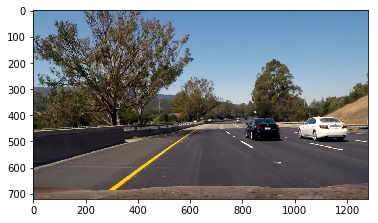

In [43]:
# read in image to test
jpg_image = cv2.imread(test_imgs[0])
jpg_image = cv2.cvtColor(jpg_image, cv2.COLOR_BGR2RGB)

# initializing the detector
veh_detector = Vehicle_Detector(param_dict)

plt.imshow(veh_detector.pipeline_efficient(jpg_image))

In [44]:
## initialize detector
veh_detector = Vehicle_Detector(param_dict)

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(veh_detector.pipeline_efficient) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [37:26<00:01,  1.78s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 37min 45s, sys: 2.45 s, total: 37min 48s
Wall time: 37min 28s


In [45]:
# Create a gif of the video output

In [4]:
clip2 = VideoFileClip("project_video_output.mp4").subclip(8,16)
clip2.write_videofile("project_video_gif.mp4")

[MoviePy] >>>> Building video project_video_gif.mp4
[MoviePy] Writing video project_video_gif.mp4


100%|█████████▉| 200/201 [00:05<00:00, 27.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_gif.mp4 

